# About

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The purpose is to learn about historical *ex ante* real interest rates in the US.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
from fredpy import series, window_equalize, quickplot
import datetime,dateutil,urllib,runProcs
import requests

# Import forecast data

In [2]:
url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xls?la=en"
r = requests.get(url,verify=False)
with open("inflationForecasts.xls", "wb") as code:
    code.write(r.content)
    
url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/medianlevel.xls?la=en"
r = requests.get(url,verify=False)
with open("medianLevel.xls", "wb") as code:
    code.write(r.content)

/Users/bcjenkin/anaconda/lib/python3.4/site-packages/requests/packages/urllib3/connectionpool.py:791: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)
/Users/bcjenkin/anaconda/lib/python3.4/site-packages/requests/packages/urllib3/connectionpool.py:791: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


In [3]:
inflationForecasts = pd.read_excel('inflationForecasts.xls')
inflationForecasts=inflationForecasts.interpolate()
# inflationForecasts.iloc[0:5]

In [4]:
deflatorForecasts = pd.read_excel('medianLevel.xls',sheetname = 'PGDP')
deflatorForecasts=deflatorForecasts.interpolate()
deflatorForecasts = deflatorForecasts.iloc[5:]
# deflatorForecasts.iloc[0:5]

In [5]:
cpiForecasts = pd.read_excel('medianLevel.xls',sheetname = 'CPI')
cpiForecasts = cpiForecasts.iloc[5:]
cpiForecasts=cpiForecasts.interpolate()
# cpiForecasts.iloc[0:5]

## GDP deflator inflation forecasts

In [6]:
# Create some fredpy instances
defl_forecast_1q = series('GDPDEF')
defl_forecast_2q = series('GDPDEF')
defl_forecast_1y = series('GDPDEF')

# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(deflatorForecasts.index):
    year =int(deflatorForecasts.iloc[i]['YEAR'])
    quart=int(deflatorForecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(400*(deflatorForecasts.iloc[i]['PGDP3']/deflatorForecasts.iloc[i]['PGDP2']-1))
    forecast_2q.append(200*(deflatorForecasts.iloc[i]['PGDP4']/deflatorForecasts.iloc[i]['PGDP2']-1))
    forecast_1y.append(100*(deflatorForecasts.iloc[i]['PGDP6']/deflatorForecasts.iloc[i]['PGDP2']-1))
    
dateNumbers = [dateutil.parser.parse(s) for s in dates]

# Update the FRED instances
defl_forecast_1q.data = np.array(forecast_1q)
defl_forecast_1q.dates = dates
defl_forecast_1q.datenumbers = dateNumbers

defl_forecast_2q.data = np.array(forecast_2q)
defl_forecast_2q.dates = dates
defl_forecast_2q.datenumbers = dateNumbers

defl_forecast_1y.data = np.array(forecast_1y)
defl_forecast_1y.dates = dates
defl_forecast_1y.datenumbers = dateNumbers

deflator_frame = pd.DataFrame({'deflator inflation - 3mo forecast':defl_forecast_1q.data,
                          'deflator inflation - 6mo forecast':defl_forecast_2q.data,
                          'deflator inflation - 1yr forecast':defl_forecast_1y.data,})

deflator_frame = deflator_frame.set_index(pd.DatetimeIndex(defl_forecast_1q.datenumbers))

## CPI inflation forecasts

In [7]:
# Create some fredpy instances

cpi_forecast_1q = series('GDPDEF')
cpi_forecast_2q = series('GDPDEF')
cpi_forecast_1y = series('GDPDEF')

# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(cpiForecasts.index):
    year =int(cpiForecasts.iloc[i]['YEAR'])
    quart=int(cpiForecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(cpiForecasts.iloc[i]['CPI3'])
    forecast_2q.append(100*(((1 + cpiForecasts.iloc[i]['CPI3']/100)*(1 + cpiForecasts.iloc[i]['CPI4']/100))**(1/2)-1))
    forecast_1y.append(100*(((1 + cpiForecasts.iloc[i]['CPI3']/100)*(1 + cpiForecasts.iloc[i]['CPI4']/100)*(1 + cpiForecasts.iloc[i]['CPI5']/100)*(1 + cpiForecasts.iloc[i]['CPI6']/100))**(1/4)-1))
    
dateNumbers = [dateutil.parser.parse(s) for s in dates]

# Update the FRED instances
cpi_forecast_1q.data = np.array(forecast_1q)
cpi_forecast_1q.dates = dates
cpi_forecast_1q.datenumbers = dateNumbers

cpi_forecast_2q.data = np.array(forecast_2q)
cpi_forecast_2q.dates = dates
cpi_forecast_2q.datenumbers = dateNumbers

cpi_forecast_1y.data = np.array(forecast_1y)
cpi_forecast_1y.dates = dates
cpi_forecast_1y.datenumbers = dateNumbers


cpi_frame = pd.DataFrame({'cpi inflation - 3mo forecast':cpi_forecast_1q.data,
                          'cpi inflation - 6mo forecast':cpi_forecast_2q.data,
                          'cpi inflation - 1yr forecast':cpi_forecast_1y.data,})

cpi_frame = cpi_frame.set_index(pd.DatetimeIndex(cpi_forecast_1q.datenumbers))

In [8]:
fr = pd.concat([cpi_frame,deflator_frame],axis=1)
# fr.plot(legend=False)

## Long-run CPI and gdp deflator forecasts

In [9]:
cpi_forecast_10y = series('GDPDEF')

cpiForecast_10y = []


# 3.3 Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(inflationForecasts.index):
    year =int(inflationForecasts.iloc[i]['YEAR'])
    quart=int(inflationForecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    cpiForecast_10y.append(inflationForecasts.iloc[i]['INFCPI10YR'])
    
dateNumbers = [dateutil.parser.parse(s) for s in dates]

# # 3.4 Create the FRED instances
cpi_forecast_10y.data = np.array(cpiForecast_10y)
cpi_forecast_10y.dates = dates
cpi_forecast_10y.datenumbers = dateNumbers

long_run_frame = pd.DataFrame({'cpi inflation - 10yr forecast':cpi_forecast_10y.data})

long_run_frame = long_run_frame.set_index(pd.DatetimeIndex(cpi_forecast_10y.datenumbers))

long_run_frame.index[-2]

Timestamp('2015-10-01 00:00:00')

In [10]:
fr = pd.concat([cpi_frame,deflator_frame,long_run_frame],axis=1)
# fr.plot(legend=False)

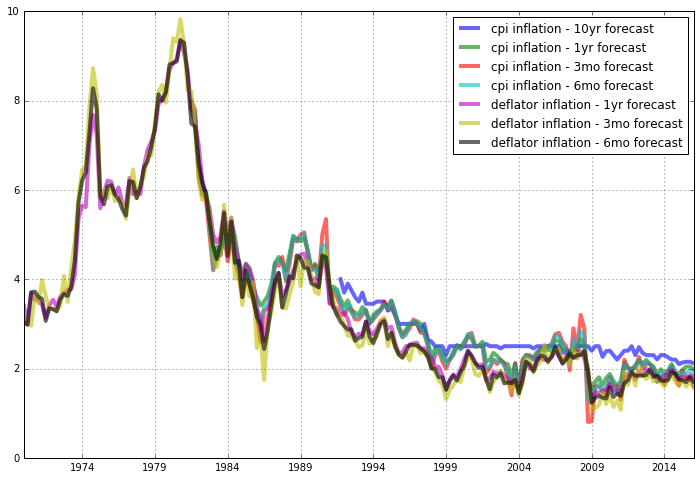

In [11]:
inflationForecasts_frame = pd.concat([long_run_frame,cpi_frame,deflator_frame],axis=1)

fig = plt.figure(figsize = (12,8))
for c in inflationForecasts_frame.columns:
    plt.plot_date(inflationForecasts_frame.index,inflationForecasts_frame[c],'-',lw=4,alpha = 0.6)
    
plt.legend()
plt.grid()

## Actual data

In [12]:
interest3mo = series('TB3MS')
interest6mo = series('TB6MS')
interest1yr = series('GS1')
interest10yr= series('GS10')

interest3mo.monthtoquarter()
interest6mo.monthtoquarter()
interest1yr.monthtoquarter()
interest10yr.monthtoquarter()

window_equalize([interest3mo,interest6mo,interest1yr,interest10yr])

interest_frame = pd.DataFrame({'interest 3mo':interest3mo.data,
                             'interest 6mo':interest6mo.data,
                             'interest 1yr':interest1yr.data,
                             'interest 10yr':interest10yr.data})
interest_frame = interest_frame.set_index(pd.DatetimeIndex(interest3mo.datenumbers))

In [13]:
fr = pd.concat([inflationForecasts_frame,interest_frame],axis=1)
# fr.plot(legend=False)

In [14]:
defl_3mo = series('GDPDEF')
defl_6mo = series('GDPDEF')
defl_1yr = series('GDPDEF')

defl_3mo.pc(method='forward',annualized=True)

data = []
for i in range(len(defl_6mo.data)-2):
    data.append(200*(defl_6mo.data[i+2]/defl_6mo.data[i]-1))
    
defl_6mo.data = np.array(data)  
defl_6mo.dates = defl_6mo.dates[:-2]
defl_6mo.datenumbers = defl_6mo.datenumbers[:-2]


data = []
for i in range(len(defl_1yr.data)-4):
    data.append(100*(defl_1yr.data[i+4]/defl_1yr.data[i]-1))
    
defl_1yr.data = np.array(data)  
defl_1yr.dates = defl_1yr.dates[:-4]
defl_1yr.datenumbers = defl_1yr.datenumbers[:-4]

defl_3mo_frame = pd.DataFrame({'deflator inflation - 3mo actual':defl_3mo.data})
defl_3mo_frame = defl_3mo_frame.set_index(pd.DatetimeIndex(defl_3mo.datenumbers))

defl_6mo_frame = pd.DataFrame({'deflator inflation - 6mo actual':defl_6mo.data})
defl_6mo_frame = defl_6mo_frame.set_index(pd.DatetimeIndex(defl_6mo.datenumbers))

defl_1yr_frame = pd.DataFrame({'deflator inflation - 1yr actual':defl_1yr.data})
defl_1yr_frame = defl_1yr_frame.set_index(pd.DatetimeIndex(defl_1yr.datenumbers))

# defl_1yr_frame.index[-2]

In [15]:
fr = pd.concat([fr,defl_1yr_frame],axis=1)
# fr.plot(legend=False)

In [16]:
cpi_3mo = series('CPIAUCSL')
cpi_6mo = series('CPIAUCSL')
cpi_1yr = series('CPIAUCSL')
cpi_10yr = series('CPIAUCSL')

cpi_3mo.monthtoquarter()
cpi_6mo.monthtoquarter()
cpi_1yr.monthtoquarter()
cpi_10yr.monthtoquarter()


cpi_3mo.pc(method='forward',annualized=True)

data = []
for i in range(len(cpi_6mo.data)-2):
    data.append(200*(cpi_6mo.data[i+2]/cpi_6mo.data[i]-1))
    
cpi_6mo.data = np.array(data)  
cpi_6mo.dates = cpi_6mo.dates[:-2]
cpi_6mo.datenumbers = cpi_6mo.datenumbers[:-2]


data = []
for i in range(len(cpi_1yr.data)-4):
    data.append(100*(cpi_1yr.data[i+4]/cpi_1yr.data[i]-1))
    
cpi_1yr.data = np.array(data)  
cpi_1yr.dates = cpi_1yr.dates[:-4]
cpi_1yr.datenumbers = cpi_1yr.datenumbers[:-4]

data = []
for i in range(len(cpi_10yr.data)-40):
    data.append(400*((cpi_10yr.data[i+40]/cpi_10yr.data[i])**(1/40)-1))
    
cpi_10yr.data = np.array(data)  
cpi_10yr.dates = cpi_10yr.dates[:-40]
cpi_10yr.datenumbers = cpi_10yr.datenumbers[:-40]

cpi_3mo_frame = pd.DataFrame({'cpi inflation - 3mo actual':cpi_3mo.data})
cpi_3mo_frame = cpi_3mo_frame.set_index(pd.DatetimeIndex(cpi_3mo.datenumbers))

cpi_6mo_frame = pd.DataFrame({'cpi inflation - 6mo actual':cpi_6mo.data})
cpi_6mo_frame = cpi_6mo_frame.set_index(pd.DatetimeIndex(cpi_6mo.datenumbers))

cpi_1yr_frame = pd.DataFrame({'cpi inflation - 1yr actual':cpi_1yr.data})
cpi_1yr_frame = cpi_1yr_frame.set_index(pd.DatetimeIndex(cpi_1yr.datenumbers))

cpi_10yr_frame = pd.DataFrame({'cpi inflation - 10yr actual':cpi_10yr.data})
cpi_10yr_frame = cpi_10yr_frame.set_index(pd.DatetimeIndex(cpi_10yr.datenumbers))

In [17]:
fr = pd.concat([fr,cpi_3mo_frame,cpi_6mo_frame,cpi_1yr_frame,cpi_10yr_frame],axis=1)
# fr.plot(legend=False)

In [18]:
actual_rates_frame = pd.concat([interest_frame,defl_3mo_frame,defl_6mo_frame,defl_1yr_frame,cpi_3mo_frame,
                                cpi_6mo_frame,cpi_1yr_frame,cpi_10yr_frame],axis = 1)

In [19]:
full_data_frame = pd.concat([actual_rates_frame,inflationForecasts_frame],axis=1)

In [20]:
full_data_frame.columns
full_data_frame[[
        'interest 3mo', 'interest 6mo', 'interest 1yr', 'interest 10yr',
       'deflator inflation - 3mo actual', 'deflator inflation - 6mo actual',
       'deflator inflation - 1yr actual', 'cpi inflation - 3mo actual',
       'cpi inflation - 6mo actual', 'cpi inflation - 1yr actual','cpi inflation - 10yr actual',
       'cpi inflation - 1yr forecast', 'cpi inflation - 3mo forecast',
       'cpi inflation - 6mo forecast', 'deflator inflation - 1yr forecast','cpi inflation - 10yr forecast',
       'deflator inflation - 3mo forecast','deflator inflation - 6mo forecast']].to_csv('inflationForecastData.csv')

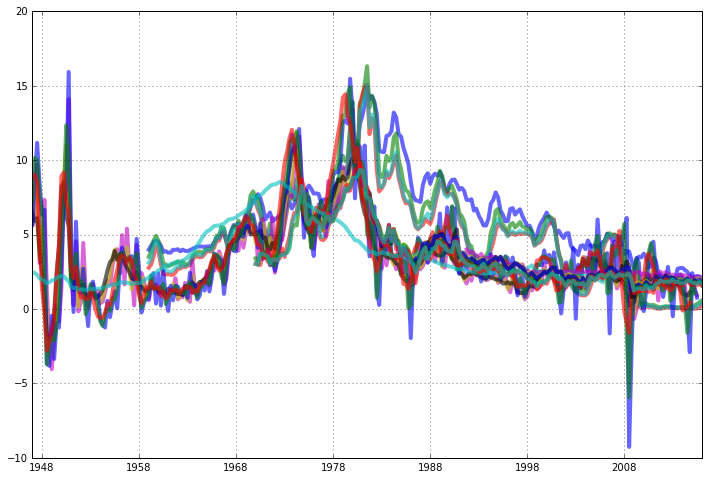

In [21]:
fig = plt.figure(figsize = (12,8))
for c in full_data_frame.columns:
    plt.plot_date(full_data_frame.index,full_data_frame[c],'-',lw=4,alpha = 0.6)
    
plt.grid()

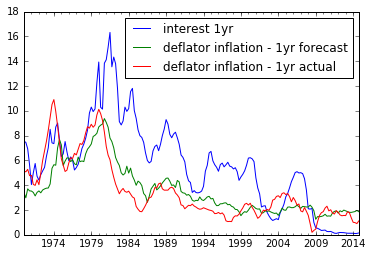

In [22]:
full_data_frame[['interest 1yr','deflator inflation - 1yr forecast','deflator inflation - 1yr actual']].dropna().plot()
# full_data_frame[].dropna().plot()

In [23]:
data_frame = full_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','interest 1yr'   ]]
data_frame = data_frame.dropna(subset = ['deflator inflation - 1yr forecast','interest 1yr'])
# data_frame = data_frame.resample('A', how='mean',convention='start',kind='timestamp')

r = data_frame['interest 1yr'] - full_data_frame['deflator inflation - 1yr forecast']
pie = data_frame['deflator inflation - 1yr forecast']
pi = data_frame['deflator inflation - 1yr actual']
i = data_frame['interest 1yr']

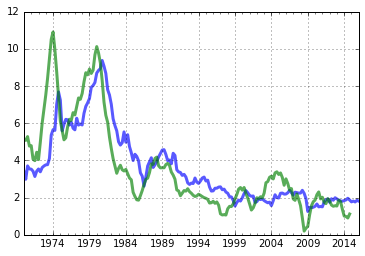

In [24]:
# r.dropna().resample('A', how='mean').plot(lw=3,alpha =.65)
# i.dropna().resample('A', how='mean').plot(lw=3,alpha =.65)
pie.plot(lw=3,alpha =.65)
pi.plot(lw=3,alpha =.65)
plt.grid()

In [25]:
data_frame

,deflator inflation - 1yr forecast,deflator inflation - 1yr actual,interest 1yr
1970-01-01,3.409091,5.155929,7.553333
1970-04-01,2.985075,5.076232,7.453333
1970-07-01,3.703704,5.279720,6.936667
1970-10-01,3.541438,4.770943,5.646667
1971-01-01,3.530259,4.792658,4.050000
1971-04-01,3.416370,4.063575,4.993333
1971-07-01,3.135889,3.985387,5.750000
1971-10-01,3.419400,4.438406,4.726667
1972-01-01,3.539209,4.042329,4.406667
1972-04-01,3.385773,4.984888,4.843333
